# **Palmer Penguins: Predicting Penguin Species via Machine Learning**
### 0. Introduction
**Motivation:**

1.	Penguin ecology provides key indicators for Antarctic environmental conditions.
2.	Species identification supports biodiversity research, population monitoring, and conservation planning.
3.	Traditional classification requires expert measurement and is difficult to scale; a streamlined ML approach can improve efficiency and reproducibility.

**Task:** Predict the species of penguins based on intrinsic biological measurements (culmen length/depth, flipper length, body mass, and sex), excluding geographic information such as island.

**Challenge:** 
1. Species distributions vary by island, creating a non-IID structure. To avoid model leakage through ecological shortcuts, we exclude Island from the features and evaluate using GroupKFold (with Island as the group) to assess generalization to unseen environments.

Alternative setting: If Island is observable at test time, we allow its inclusion as a predictor and use StratifiedKFold for standard evaluation.

2. Missing values in some features

**Problem Type:**
Classification

**Target Variable:** Species (Categorical)

**Data Source:** Palmer Penguins dataset, collected by Dr. Kristen Gorman and the Palmer Station LTER. The dataset contains open-access biological and contextual measurements for multiple penguin species.

**Goal:** Develop a compact classification pipeline, perform feature selection, train multiple ML models, evaluate with cross-validation, and visualize decision regions to assess separability and model performance.


Three kinds of Plamer Penguins in this dataset:

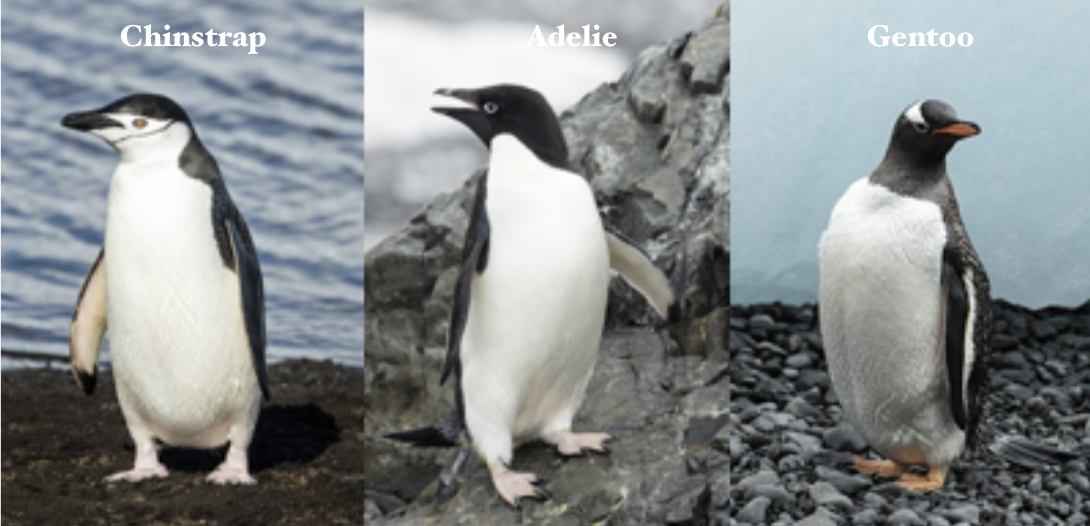

## 1. Data Import and Cleaning

1.1 Import Necessary libraries**

In [ ]:
# libraries
import pandas as pd
import numpy as np
import random
import urllib

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree

# evaluation metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

**Step 2: load the data**

In [78]:
np.random.seed(42)
# From github url, import Palmer Penguins dataset as a pd.dataframe
penguins = pd.read_csv('data/palmer_penguins.csv')
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


For convenience, we use the first string as the penguin's name.

In [79]:
penguins["Species"] = penguins["Species"].str.split().str[0]

**Step 3: preliminary examination of the dataset's structure.**

Here, we explore the structure of the Palmer Penguins dataset by examining its size and the data types of each column. This step allows us to become familiar with the dataset, identify its characteristics, and pinpoint any potential issues before proceeding with further analysis.

In [80]:
shape = penguins.shape
# find the shape of the penguins dataframe
print("Shape of the penguins dataframe is:", shape, "\n")

datatypes = penguins.dtypes
# find the datatypes of each column within the dataframe penguins
print("The datatype of each of the columns of penguins dataframe is:\n", datatypes)

Shape of the penguins dataframe is: (344, 17) 

The datatype of each of the columns of penguins dataframe is:
 studyName               object
Sample Number            int64
Species                 object
Region                  object
Island                  object
Stage                   object
Individual ID           object
Clutch Completion       object
Date Egg                object
Culmen Length (mm)     float64
Culmen Depth (mm)      float64
Flipper Length (mm)    float64
Body Mass (g)          float64
Sex                     object
Delta 15 N (o/oo)      float64
Delta 13 C (o/oo)      float64
Comments                object
dtype: object


In [81]:
# extract the column names from the dataframe as a list
p_columns = list(penguins.columns)

# initialize an empty dictionary to store the count of NaN values for each column
nan_dict = {}

# iterate through each column in the dataframe
for i in range(len(p_columns)):
    # check for NaN values in the current column
    is_null = penguins[p_columns[i]].isna()
    # update the dictionary with the column name as key and count of NaN values as value
    nan_dict.update({p_columns[i]: is_null.sum()})

# iterate through the dictionary to print the NaN counts for each column
for key, val in nan_dict.items():
    print("There are ", val, " missing values within column [", key, "]")

There are  0  missing values within column [ studyName ]
There are  0  missing values within column [ Sample Number ]
There are  0  missing values within column [ Species ]
There are  0  missing values within column [ Region ]
There are  0  missing values within column [ Island ]
There are  0  missing values within column [ Stage ]
There are  0  missing values within column [ Individual ID ]
There are  0  missing values within column [ Clutch Completion ]
There are  0  missing values within column [ Date Egg ]
There are  2  missing values within column [ Culmen Length (mm) ]
There are  2  missing values within column [ Culmen Depth (mm) ]
There are  2  missing values within column [ Flipper Length (mm) ]
There are  2  missing values within column [ Body Mass (g) ]
There are  10  missing values within column [ Sex ]
There are  14  missing values within column [ Delta 15 N (o/oo) ]
There are  13  missing values within column [ Delta 13 C (o/oo) ]
There are  318  missing values within col

In [82]:
penguins["Region"].unique() , penguins["Stage"].unique(), 
penguins['Clutch Completion'].unique(), penguins['Comments'].unique(), 


(array(['Anvers'], dtype=object),
 array(['Adult, 1 Egg Stage'], dtype=object),
 array(['Yes', 'No'], dtype=object),
 array(['Not enough blood for isotopes.', nan, 'Adult not sampled.',
        'Nest never observed with full clutch.',
        'No blood sample obtained.',
        'No blood sample obtained for sexing.',
        'Nest never observed with full clutch. Not enough blood for isotopes.',
        'Sexing primers did not amplify. Not enough blood for isotopes.'],
       dtype=object))

In [83]:
from sklearn.feature_selection import mutual_info_classif
enc_clutch = {'Yes':1, 'No':0}
encoded_clutch = penguins['Clutch Completion'].map(enc_clutch)
encoded_clutch = encoded_clutch.values.reshape(-1,1)
mi = mutual_info_classif(encoded_clutch, penguins['Species'], discrete_features=True)
print(mi)

[0.01262728]


In [120]:
print('Before cleaning the sex:', penguins['Sex'].unique())
penguins['Sex'] = penguins['Sex'].replace('.', np.nan)
penguins['Sex'] = penguins['Sex'].fillna('Unknown')
print('After cleaning the sex:', penguins['Sex'].unique())


Before cleaning the sex: ['MALE' 'FEMALE' nan]
After cleaning the sex: ['MALE' 'FEMALE' 'Unknown']


All the penguins in the dataset come from the same region, and all share the stage “Adult, 1 Egg Stage,” which means these two variables lack variability and do not offer distinguishing power for analysis. Additionally, the Individual ID is likely a unique identifier for each penguin and does not represent any biological or behavioral significance, making it unsuitable for analysis. Including it could introduce noise or potentially lead to overfitting in predictive models. The Clutch Completion column, indicating whether the clutch (set of eggs) was completed (e.g., “Yes”), might hold relevance in ecological contexts but is unlikely to contribute meaningfully to species classification or other predictive analysis as the chi statistic is near 0. 

Similarly, the Egg Date may not provide meaningful insights for species classification or biological analysis unless it aligns with a seasonal or temporal factor. If the date is constant or unrelated to the outcomes of interest, it is not a priority feature. Therefore, we will categorize the remaining columns into quantitative and qualitative variables for further exploration.

In [85]:
continuous_feature = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
categorical_feature = ["Species", "Island", "Sex"]
penguins = penguins[continuous_feature+categorical_feature]

## 2. Exploratory Analysis

In this part, we conducted exploratory data analysis (EDA) to gain an initial understanding of the dataset’s structure and the relationships within the data. We began by summarizing the dataset, grouping the penguins by species and sex, and calculating the average values of key numerical features such as culmen length, culmen depth, flipper length, body mass, and isotopic measurements (Delta 15N and Delta 13C). Next, we grouped the penguins by island to analyze the distribution of species across the islands. To enhance our analysis and facilitate feature selection, we visualized the data using violin plots, scatterplots, boxplots, and histograms.

### Table 1: Penguin Statistics Summary by Species and Sex

In [86]:
# take the average of each numerical measurement by Species and by Sex.
stat_penguin = penguins.drop(columns = "Island")
stat_penguin.groupby(["Species", "Sex"]).mean()

Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
Species   Sex                                                                  
Adelie    FEMALE           37.257534          17.621918           187.794521   
          MALE             40.390411          19.072603           192.410959   
Chinstrap FEMALE           46.573529          17.588235           191.735294   
          MALE             51.094118          19.252941           199.911765   
Gentoo    FEMALE           45.563793          14.237931           212.706897   
          MALE             49.473770          15.718033           221.540984   

                  Body Mass (g)  Delta 15 N (o/oo)  Delta 13 C (o/oo)  
Species   Sex                                                          
Adelie    FEMALE    3368.835616           8.793275         -25.794158  
          MALE      4043.493151           8.928437         -25.833813  
Chinstrap FEMALE    3527.205882           9.250962         -24.565405  
          MALE      3938.970588           9.464535         -24.527679  
Gentoo    FEMALE    4679.741379           8.193405         -26.197205  
          MALE      5484.836066           8.303429         -26.170608

Notably, males across all species tend to exhibit larger physical features than females, highlighting a clear pattern of sexual dimorphism. For instance, male Gentoo penguins have significantly greater flipper lengths and body masses compared to females, showcasing their robust build. Similarly, the Chinstrap species has the largest culmen length averages, distinguishing it from the Adelie and Gentoo species. Beyond physical attributes, the isotopic measurements (Delta 15N and Delta 13C) show minimal variation between sexes within the same species but differ slightly across species, potentially reflecting differences in diet or habitat. The Gentoo species, in particular, stands out with the highest body mass and flipper length, underscoring its physical dominance among the species.

### Table 2: Penguin Count by Island

In [87]:
# count the number of penguins on each island based on a specific column
# cleaned_penguin.groupby(["Island", "Species"]).size()
penguins.groupby(["Island", "Species"]).size().reset_index(name="Penguin Count")


,Island,Species,Penguin Count
0,Biscoe,Adelie,44
1,Biscoe,Gentoo,124
2,Dream,Adelie,56
3,Dream,Chinstrap,68
4,Torgersen,Adelie,52


This table provides an overview of penguin populations categorized by species and island. It shows that Gentoo penguins dominate the population on Biscoe Island, with a total count of 124, followed by 44 Adelie penguins. Chinstrap penguins are exclusively found on Dream Island, where they represent a population of 68, alongside 56 Adelie penguins. Torgersen Island is exclusively home to 52 Adelie penguins. The distribution highlights that Gentoo penguins are concentrated on Biscoe Island, Chinstrap penguins are restricted to Dream Island, and Adelie penguins are the only species spread across all three islands, although their numbers vary.

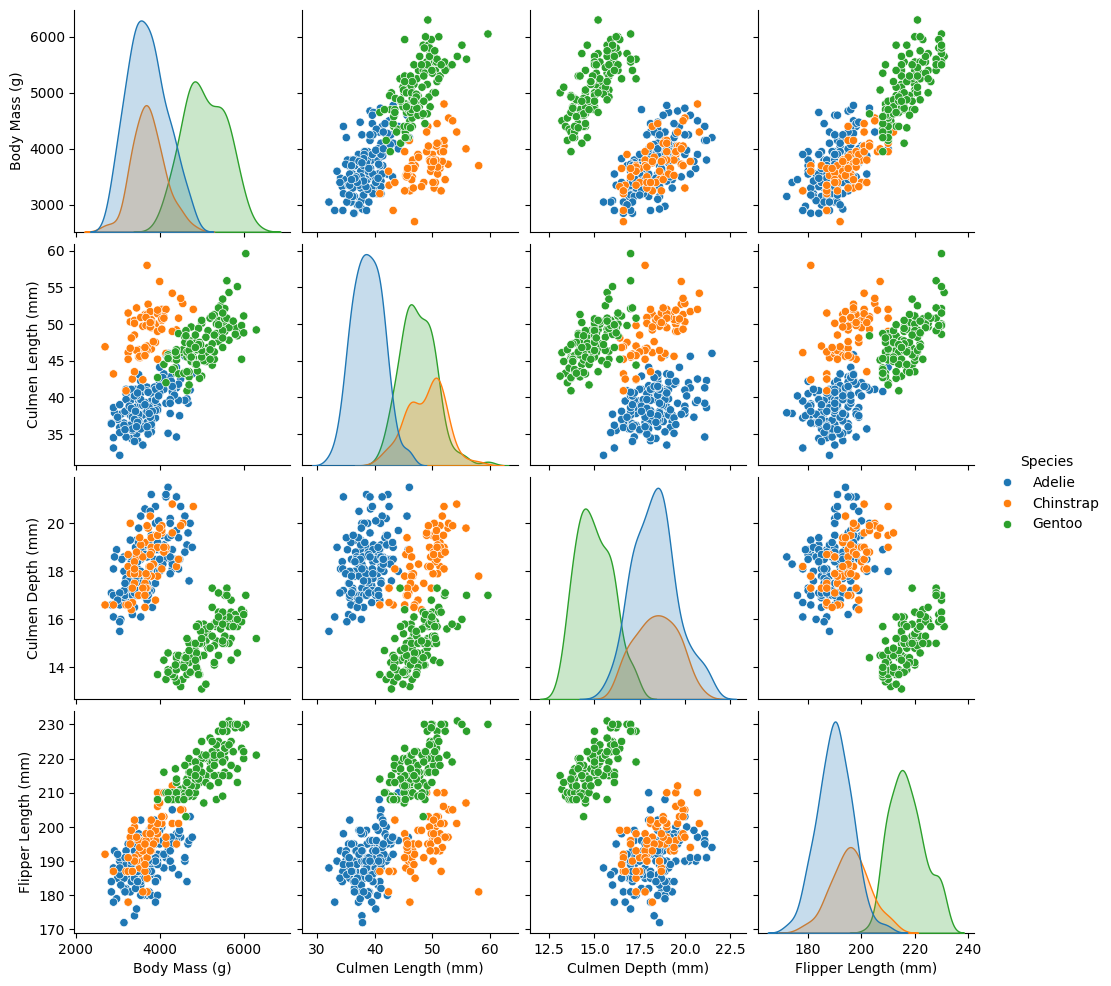

In [96]:
sns.pairplot(penguins, 
             hue = 'Species', 
             vars=["Body Mass (g)", 
                    "Culmen Length (mm)",
                    "Culmen Depth (mm)",
                    "Flipper Length (mm)"],
    diag_kind="kde",
    corner= False,
        )
plt.show()

### Figure 1: Scatter Plot of Culmen Length vs. Culmen Depth by Species
The scatter plot visualizes the relationship between Culmen Length (mm) and Culmen Depth (mm) for different penguin species across various islands. Each subplot represents data either aggregated for all islands or filtered for individual islands.

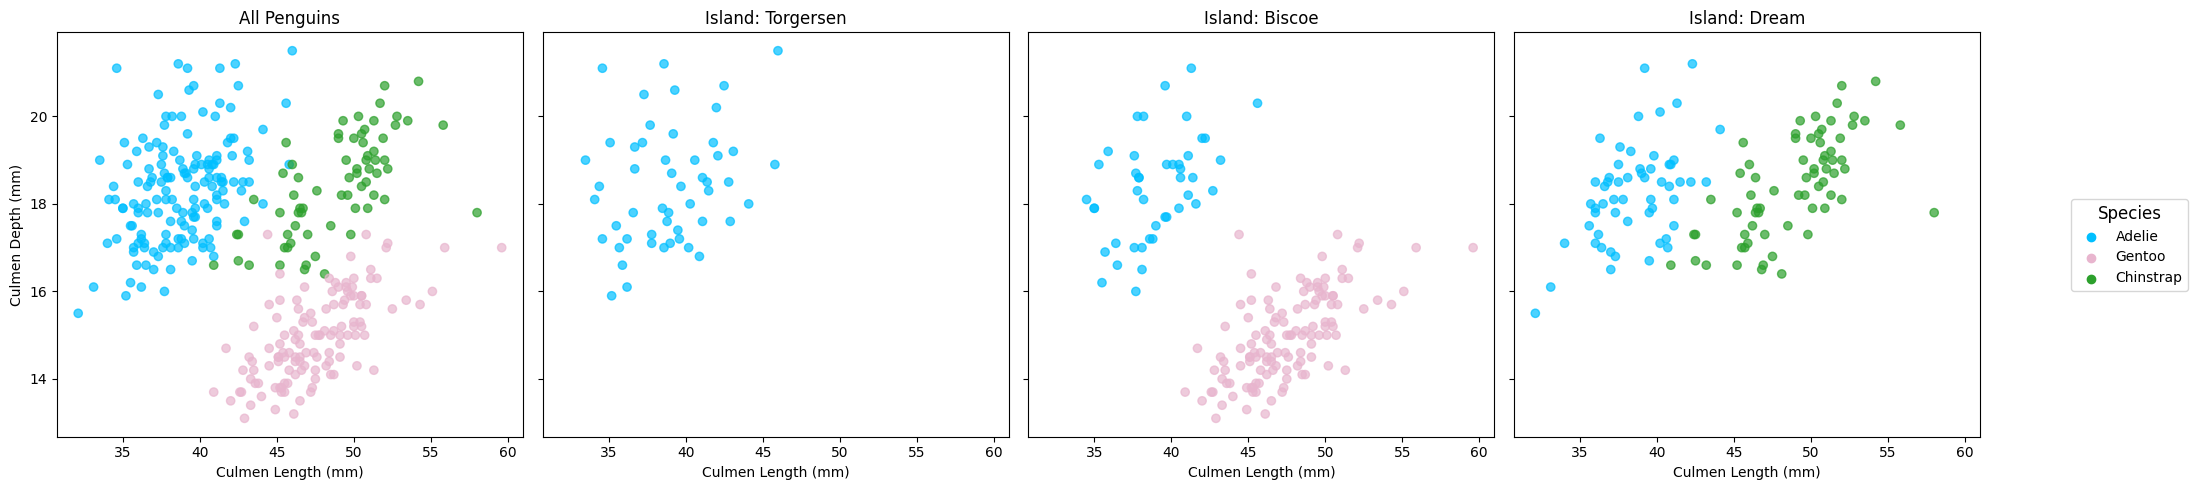

In [88]:
# extract relevant columns for scatter plots
penguins_scatter = penguins[["Island", "Species", "Culmen Length (mm)", "Culmen Depth (mm)"]]

# get unique islands for filtering plots
islands = penguins_scatter["Island"].unique()

# define a color map for species
color_map = {
    "Adelie": "#00BFFF",  # blue for adelie
    "Gentoo": "#e8b5ce",  # pink for gentoo
    "Chinstrap": "#2ca02c",  # green for chinstrap
}

# create subplots with shared x and y axes
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)

# plot all penguins on the first subplot
axes[0].scatter(
    penguins_scatter["Culmen Length (mm)"],
    penguins_scatter["Culmen Depth (mm)"],
    c=penguins_scatter["Species"].map(color_map),  # map species to colors
    alpha=0.7,  # set transparency for better visualization
)
axes[0].set_title("All Penguins")  # set title for the first subplot
axes[0].set_xlabel("Culmen Length (mm)")  # set x-axis label for the first subplot

# add legend entries for species in the first plot
for species, color in color_map.items():
    axes[0].scatter([], [], color=color, label=species)

# iterate through each island and create a scatter plot for each
for i, subisland in enumerate(islands):
    ax = axes[i + 1]
    data = penguins_scatter[penguins_scatter["Island"] == subisland]
    ax.scatter(
        data["Culmen Length (mm)"],
        data["Culmen Depth (mm)"],
        c=data["Species"].map(color_map),  # map species to colors
        alpha=0.7,  # set transparency for better visualization
    )
    ax.set_title(f"Island: {subisland}")  # set title based on island name
    ax.set_xlabel("Culmen Length (mm)")  # set x-axis label for each island plot

# set the shared y-axis label
axes[0].set_ylabel("Culmen Depth (mm)")

# add a legend for species on the right of the figure
fig.legend(
    title="Species",
    loc="right",
    bbox_to_anchor=(1.1, 0.5),
    fontsize=10,
    title_fontsize=12,
)

# adjust layout for better spacing
plt.tight_layout()
plt.show()

The scatter plot effectively illustrates the distribution of penguins on each island, corresponding to the information presented in Table 2. However, this visualization is not ideal for detailed data analysis. While it highlights the distinct characteristics of Gentoo penguins (pink), which have longer culmen lengths and smaller depths, it also reveals significant overlap between Adelie (blue) and Chinstrap (green) penguins, particularly in the mid-range culmen lengths.

### Figure 2: Box Plot of Flipper Length and Body Mass by Species

Then let's use a boxplot to see whether flipper length and body mass show clear distinctions between species.

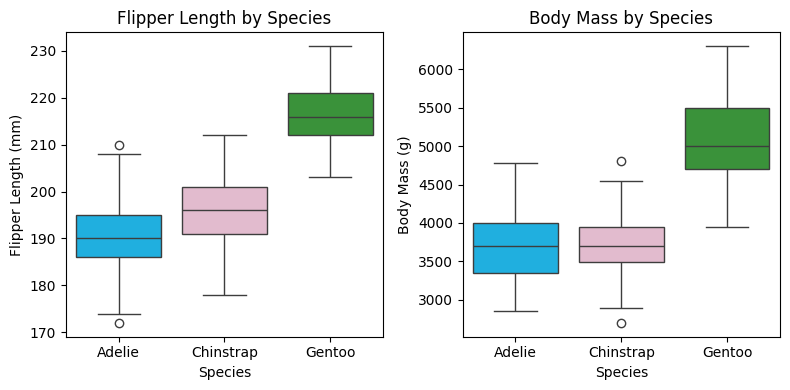

In [89]:
# selecting only the relevant columns from cleaned_penguin for plotting
penguin_boxplot = penguins[["Species", "Flipper Length (mm)", "Body Mass (g)"]]

# creating a figure with two subplots in a single row and setting figure size
fig, axes = plt.subplots(1, 2, figsize = (8, 4))

# creating a boxplot for flipper length grouped by species
sns.boxplot(
            data = penguin_boxplot, # specifying data source
            x = "Species", # x-axis variable (species)
            y = "Flipper Length (mm)", # y-axis variable (flipper length)
            ax = axes[0], # assigning plot to the first subplot
            palette = ["#00BFFF","#e8b5ce","#2ca02c"], # setting color palette
            hue = "Species" # adding species as a grouping hue
)
# setting the title, x-axis label, and y-axis label for the first subplot
axes[0].set_title("Flipper Length by Species")
axes[0].set_ylabel("Flipper Length (mm)")

# creating a boxplot for body mass grouped by species
sns.boxplot(
            data = penguin_boxplot, # specifying data source
            x = "Species", # x-axis variable (species)
            y = "Body Mass (g)", # y-axis variable (body mass)
            ax = axes[1], # assigning plot to the second subplot
            palette = ["#00BFFF","#e8b5ce","#2ca02c"], # setting color palette
            hue = "Species" # adding species as a grouping hue
)
# setting the title, x-axis label, and y-axis label for the second subplot
axes[1].set_title("Body Mass by Species")
axes[1].set_ylabel("Body Mass (g)")

# adjusting layout to prevent overlap of subplots
plt.tight_layout()

# displaying the plots
plt.show()

These two boxplots compare flipper length and body mass across three penguin species. In the left plot, Adelie penguins have the shortest median flipper length, around 190 mm, with low variability and a few outliers on the lower end. Chinstrap penguins show a slightly higher median flipper length of approximately 195–200 mm, with greater variability compared to Adelie penguins. Gentoo penguins, on the other hand, have the longest median flipper length, around 220 mm, with a narrow range and no apparent outliers. In the right plot, Adelie penguins have the lowest median body mass, about 3500 g, followed by Chinstrap penguins with a slightly higher median of 3750–4000 g, both showing moderate variability and a few lower outliers. Gentoo penguins exhibit the highest median body mass, approximately 5000 g, with more variability but no significant outliers. Overall, Gentoo penguins are distinct in both flipper length and body mass, being larger and more consistent in flipper length but more variable in body mass, while Adelie and Chinstrap penguins show overlapping characteristics that make them more similar to each other.


### Figure 3: Histogram of Delta 15 N and Delta 13 C by Species
Then we would like to use a Histogram model to visualize the Delta 15 N and Delta 13 C data of each species.

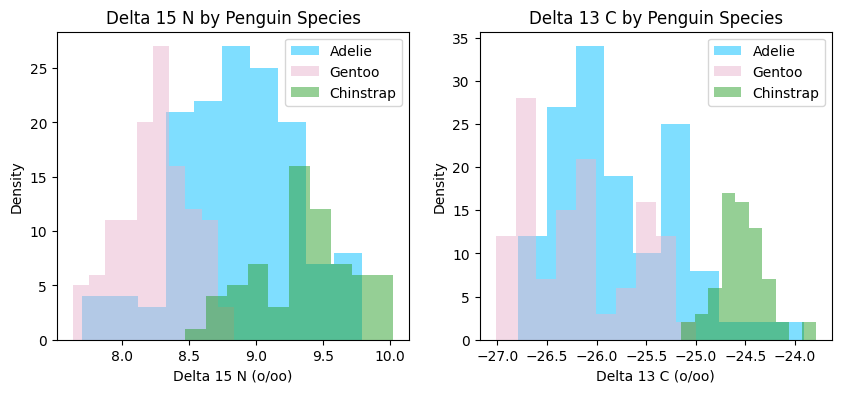

In [90]:
penguins_hist = penguins[["Species", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]]

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].set(xlabel = "Delta 15 N (o/oo)",
       ylabel = "Density")
# create a figure, set the axis
species = set(penguins_hist['Species'])

# graph the species as a histogram
for s in species:
    subspecies = penguins_hist[penguins_hist['Species'] == s]
    ax[0].hist(subspecies['Delta 15 N (o/oo)'], color = color_map[s], label = s, alpha = 0.5)
ax[0].set_title("Delta 15 N by Penguin Species")
ax[0].legend()

ax[1].set(xlabel = "Delta 13 C (o/oo)",
       ylabel = "Density")
# create a figure, set the axis
species = set(penguins['Species'])

# graph the species as a histogram
for s in species:
    subspecies = penguins_hist[penguins_hist['Species'] == s]
    ax[1].hist(subspecies['Delta 13 C (o/oo)'], color = color_map[s], label = s, alpha = 0.5)

ax[1].set_title("Delta 13 C by Penguin Species")
ax[1].legend()

These histograms visualize the density distributions of isotopic measurements (Delta 15 N and Delta 13 C) the three species.

In the first plot (“Delta 15 N by Penguin Species”), Delta 15 N shows distinct patterns across species. Chinstrap penguins have higher values concentrated around 9.5–10, whereas Gentoo penguins are centered around 8–8.5. Adelie penguins display a broader distribution, overlapping both Chinstrap and Gentoo distributions, but their density peaks around 8.5–9.

In the second plot (“Delta 13 C by Penguin Species”), Delta 13 C values reveal another separation. Gentoo penguins have the most negative values, primarily between -27 and -26, while Adelie penguins dominate the middle range around -26 to -25. Chinstrap penguins have the least negative Delta 13 C values, clustering around -24.5 to -25.

In summary, although Delta 15 N and Delta 13 C can exhibit trend differences within certain ranges, the overlap may make it difficult for classification models to achieve high accuracy relying solely on these two features.

### Figure 4: Violin Plot of Quantitative Features Grouped by Species and Sex

Finally, to better visualize the relationship between numerical and categorical data, we utilized violin plots to aggregate and analyze the distributions effectively.

In [98]:
# assign the cleaned penguin dataset
penguin_violinMap = penguins

# create subplots based on the number of quantitative columns
fig, axes = plt.subplots(2, len(penguins) // 2, figsize=(4 * (len(penguins) // 2), 8))
axes = axes.flatten()  # flatten axes for easier iteration

# initialize handles and labels for the legend
handles, labels = [], []

# iterate over quantitative columns to create violin plots
for i, var in enumerate(penguins):
    sns.violinplot(
        data = penguin_violinMap,  # use the cleaned dataset
        x = "Species",  # group by species
        y = var,  # quantitative variable for the y-axis
        hue = "Sex",  # split by sex
        palette = {"MALE": "#80e5ff", "FEMALE": "#ffb3ff"},  # color palette for sexes
        split = True,  # split violin plots by hue
        ax = axes[i]  # assign subplot
    )
    axes[i].set_title(f"{var} by Species and Sex")  # set title for each plot
    axes[i].set_ylabel(var)  # set y-axis label
    axes[i].get_legend().set_visible(False)  # hide individual plot legends

    # capture legend handles and labels from the first plot
    if i == 0:
        handles, labels = axes[i].get_legend_handles_labels()

# add a single legend for all subplots
fig.legend(
          handles,  # legend handles
          labels,  # legend labels
          loc = 'center right',  # position legend to the right of the plots
          title = "Sex",  # set legend title
          bbox_to_anchor = (1.1, 0.5)  # position legend outside of the figure
)

# adjust layout for better spacing
plt.tight_layout()
plt.show()

In the violin plot, while some distinctions can be observed between males and females within the same species—such as males generally having larger body mass and longer flippers—the overall differences are not pronounced enough to serve as a clear distinguishing factor for species classification. This suggests that sex alone does not significantly contribute to differentiating penguin species.

## Feature Selection and Modeling

The violin plot clearly demonstrates that sex has limited ability to differentiate between penguin species. Its distribution shows significant overlap across species, making it a low-information feature that is unsuitable for classification purposes. In contrast, island is shown to be a highly informative categorical feature, as highlighted in Table 2 and figure 1(scatter plot). Penguin species exhibit distinct geographic distributions: Gentoo and Adelie are found only on Biscoe Island, Chinstrap and Adelie are found only on Dream Island, and Adelie is the sole species on Torgersen Island. This geographic separation significantly reduces classification uncertainty, making island an essential categorical variable for the model.

The violin plots also provide strong support for the inclusion of culmen length and culmen depth as key quantitative features. These two features not only exhibit strong overall separation between species but also allow for direct differentiation of certain species. For example, Adelie penguins can be identified by their significantly shorter culmen lengths, while Gentoo penguins are characterized by their shallower culmen depths. Once Adelie and Gentoo are classified using these features, the remaining group—Chinstrap—can be easily identified, completing the classification. The combination of culmen length and culmen depth captures richer feature space information, enhancing the model’s discriminative ability.

The box plots of flipper length and body mass highlight their potential as additional features. While Gentoo penguins are clearly separable in both dimensions, Adelie and Chinstrap penguins show considerable overlap, reducing their effectiveness for distinguishing these two species. However, these features may still complement culmen length and culmen depth, particularly in separating Gentoo penguins from the other species.

The histograms of Delta 15 N and Delta 13 C reveal significant overlap between species, indicating limited discriminatory power for classification. These features are therefore less informative and were excluded from the feature set. Similarly, the violin plots reaffirm the limited utility of sex as a classification variable due to the lack of meaningful variation across species.

In conclusion, culmen length and culmen depth were selected as the primary quantitative variables for their strong differentiating capabilities, while island was chosen as the categorical variable due to its ability to reduce classification uncertainty. Although flipper length and body mass show overlap for some species, they may still contribute as supplementary features, particularly for separating Gentoo penguins. This carefully curated feature set ensures the model leverages the most significant interspecies differences for accurate classification.

To ensure robust predictions, we selected three models with complementary strengths:
1. Logistical Regression
2. Random Forest
3. Support Vector Machine

In [183]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import MissingIndicator
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, GridSearchCV, GroupShuffleSplit, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix

### Logistic Regression

Logistic regression is a fundamental classification algorithm used to predict the probability of a binary outcome (e.g., classifying between two species). For multi-class classification (like in the Palmer Penguins dataset), logistic regression uses a multinomial extension. This model is popular due to its simplicity, interpretability, and effectiveness for linearly separable data. Below, we will steps to implement a logistic regression model and discuss evaluate its performance using accuracy score, confusion matrix, classification report, and decision regions.

In [172]:
y = penguins['Species']
le = LabelEncoder()
y= le.fit_transform(y)
X = penguins.drop(columns=['Species'])

numerical_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
categorical_features = ["Sex"]

# numeric = missing indicator only (no scaler, no impute)
numeric_transform = MissingIndicator(features='all')

# categorical = one-hot (NaN handled automatically)
categorical_transform = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
                    ('num_miss', numeric_transform, numerical_features),
                    ('cat', categorical_transform, categorical_features)
    ]
)

islands = ['Dream', 'Biscoe', 'Torgersen']
splits = []

for i in range(3):
    other_island = islands[i]
    train_islands = [islands[j] for j in range(3) if j != i]
    splits.append({
        'train_islands': train_islands,
        'other_islands': other_island  # will be split into val/test
    })


param_grid = {'penalty':['l1', 'l2'],
             'C': np.logspace(-3,2,7),
             'solver': ['liblinear', 'saga'],
             'max_iter': [1000]}

train_score = np.zeros(len(ParameterGrid(param_grid)))
val_score = np.zeros(len(ParameterGrid(param_grid)))
models = []

for p in range(len(ParameterGrid(param_grid))):
    params = ParameterGrid(param_grid)[p]
    fold_train_acc = []
    fold_val_acc = []

    for split in splits:
        train_islands = split['train_islands']
        test_islands = split['other_islands']
        train_mask = penguins['Island'].isin(train_islands)
        other_mask = penguins['Island'] == test_islands
        X_train, y_train = X[train_mask], y[train_mask]
        X_other, y_other = X[other_mask], y[other_mask]

        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

        lg = Pipeline([('preprocessor', preprocessor),
                        ('Classifier', LogisticRegression(**params, random_state=42))])
        
        lg.fit(X_train, y_train)
        train_acc = accuracy_score(y_train, lg.predict(X_train))
        val_acc = accuracy_score(y_val, lg.predict(X_val))

        fold_train_acc.append(train_acc)
        fold_val_acc.append(val_acc)

    # Store mean scores
    train_score[p] = np.mean(fold_train_acc)
    val_score[p] = np.mean(fold_val_acc)
    models.append(lg)

for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Params: {params}")
    print(f"  Avg Train Accuracy: {train_score[i]:.4f}")
    print(f"  Avg Val Accuracy:   {val_score[i]:.4f}\n")

best_idx = np.argmax(val_score)
print(f"Best parameters: {ParameterGrid(param_grid)[best_idx]}")

final_model = models[best_idx]
fold_test_acc = []
for split in splits:
    other_mask = penguins['Island'] == split['other_islands']
    _, X_test, _, y_test = train_test_split(
        X[other_mask], y[other_mask], test_size=0.5, random_state=42, stratify=y[other_mask]
    )
    y_test_pred = final_model.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    fold_test_acc.append(acc)

print(f"\nAvg Final Test Accuracy: {np.mean(fold_test_acc):.4f}")

Params: {'C': np.float64(0.001), 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
  Avg Train Accuracy: 0.4642
  Avg Val Accuracy:   0.5205

Params: {'C': np.float64(0.001), 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
  Avg Train Accuracy: 0.5066
  Avg Val Accuracy:   0.3968

Params: {'C': np.float64(0.001), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
  Avg Train Accuracy: 0.5340
  Avg Val Accuracy:   0.0635

Params: {'C': np.float64(0.001), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
  Avg Train Accuracy: 0.5340
  Avg Val Accuracy:   0.0635

Params: {'C': np.float64(0.006812920690579615), 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
  Avg Train Accuracy: 0.4642
  Avg Val Accuracy:   0.5205

Params: {'C': np.float64(0.006812920690579615), 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
  Avg Train Accuracy: 0.5066
  Avg Val Accuracy:   0.3968

Params: {'C': np.float64(0.006812920690579615), 'max_iter': 1000, 'penalty': 'l2', 's

**XGBClassifier**

      Island  Accuracy
0  Torgersen  0.961538
1     Biscoe  0.261905
2      Dream  0.451613


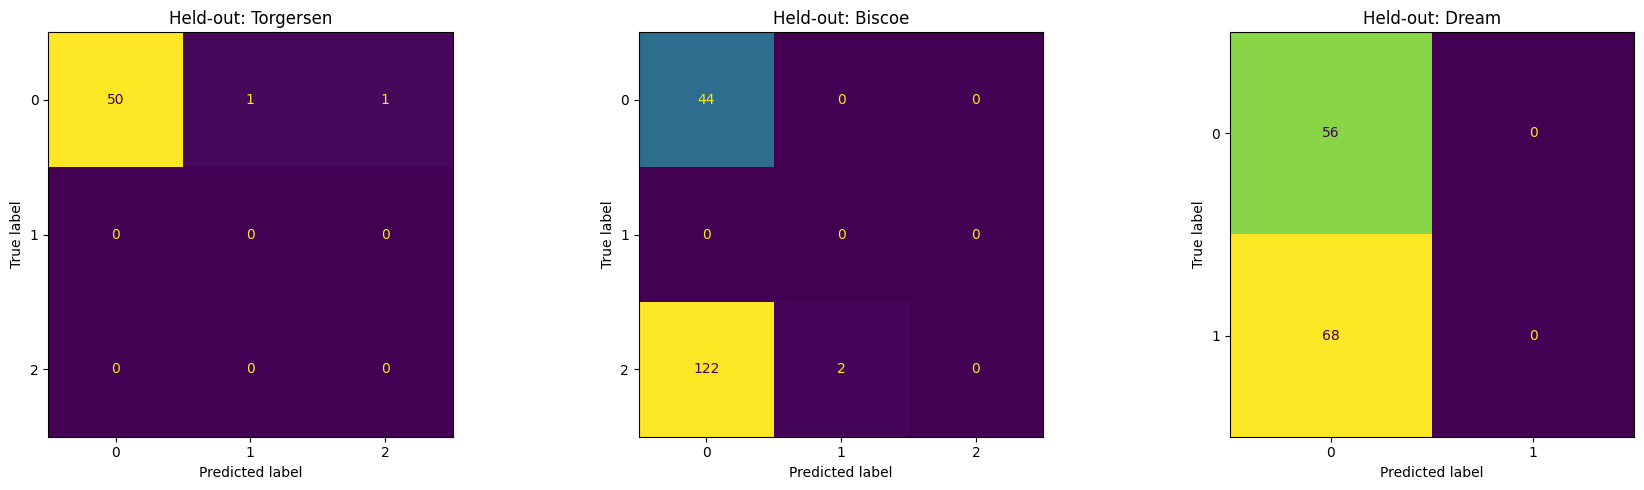

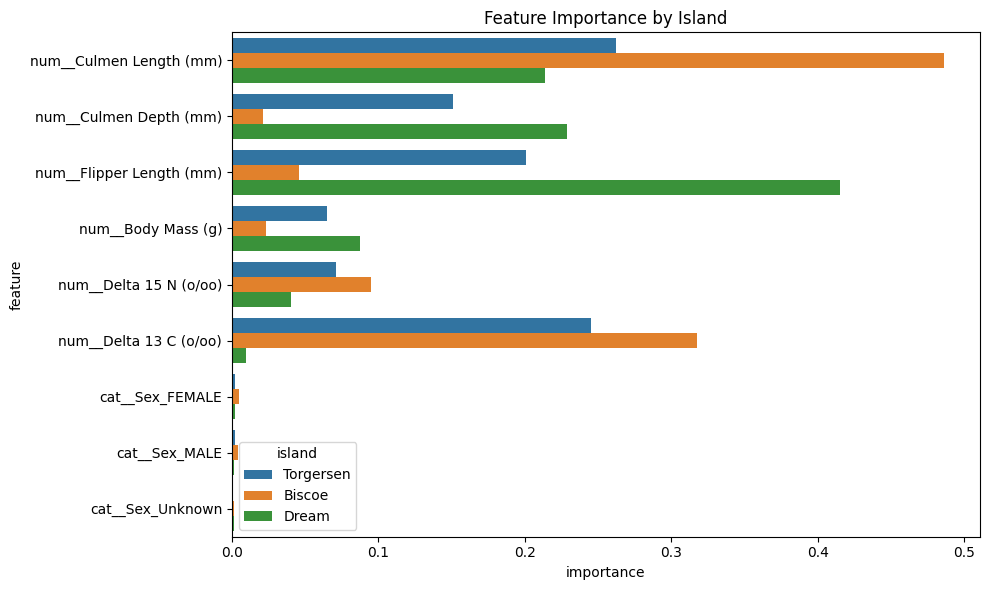

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island,Sex,EncodedSpecies,true,pred,island
19,46.0,21.5,194.0,4200.0,9.11616,-24.77227,Torgersen,MALE,0,0,1,Torgersen
129,44.1,18.0,210.0,4000.0,9.10702,-26.01363,Torgersen,MALE,0,0,2,Torgersen
220,46.1,13.2,211.0,4500.0,7.99300,-25.51390,Biscoe,FEMALE,2,2,0,Biscoe
221,50.0,16.3,230.0,5700.0,8.14756,-25.39369,Biscoe,MALE,2,2,0,Biscoe
222,48.7,14.1,210.0,4450.0,8.14705,-25.46172,Biscoe,FEMALE,2,2,0,Biscoe
223,50.0,15.2,218.0,5700.0,8.25540,-25.40075,Biscoe,MALE,2,2,0,Biscoe
224,47.6,14.5,215.0,5400.0,8.23450,-25.54456,Biscoe,MALE,2,2,0,Biscoe
225,46.5,13.5,210.0,4550.0,7.99530,-25.32829,Biscoe,FEMALE,2,2,0,Biscoe
226,45.4,14.6,211.0,4800.0,8.24515,-25.46782,Biscoe,FEMALE,2,2,0,Biscoe
227,46.7,15.3,219.0,5200.0,8.22673,-25.42760,Biscoe,MALE,2,2,0,Biscoe


In [198]:
y = penguins["Species"]
y_encoded = LabelEncoder().fit_transform(y)
X = penguins.drop(columns=["Species"])
groups = penguins["Island"]
islands = groups.unique()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_feature)
])


rf_pipeline = Pipeline([
                        ("preprocessor", preprocessor),
                        ("classifier", RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])


results = []
confusions = {}
misclassified_rows = []
feature_importances = []

for heldout_island in islands:
    train_mask = groups != heldout_island
    test_mask = groups == heldout_island

    X_train, y_train = X[train_mask], y_encoded[train_mask]
    X_test, y_test = X[test_mask], y_encoded[test_mask]

    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)

    # accuracy
    acc = accuracy_score(y_test, y_pred)

    # confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    confusions[heldout_island] = cm

    # store misclassified
    mis_X = X_test[y_pred != y_test].copy()
    mis_X["true"] = y_test[y_pred != y_test]
    mis_X["pred"] = y_pred[y_pred != y_test]
    mis_X["island"] = heldout_island
    misclassified_rows.append(mis_X)

    # feature importances
    importances = rf_pipeline.named_steps["classifier"].feature_importances_
    feature_names = rf_pipeline.named_steps["preprocessor"].get_feature_names_out()
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
        "island": heldout_island
    })
    feature_importances.append(fi_df)

    results.append({
        "Island": heldout_island,
        "Accuracy": acc
    })

results_df = pd.DataFrame(results)
print(results_df)

# Confusion matrix plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for ax, island in zip(axs, islands):
    ConfusionMatrixDisplay(confusions[island]).plot(ax=ax, colorbar=False)
    ax.set_title(f"Held-out: {island}")
plt.tight_layout()
plt.show()

# Feature importance
feature_df = pd.concat(feature_importances)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x="importance", y="feature", hue="island")
plt.title("Feature Importance by Island")
plt.tight_layout()
plt.show()

# Misclassified samples
misclassified_df = pd.concat(misclassified_rows)
misclassified_df.head(10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# numeric = missing indicator only (no scaler, no impute)
numeric_transform = MissingIndicator(features='all')

# categorical = one-hot (NaN handled automatically)
categorical_transform = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
                    ('num_miss', numeric_transform, numerical_features),
                    ('cat', categorical_transform, categorical_features)
    ]
)


logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(tree_method='hist', n_estimators=300, learning_rate=0.1, max_depth=4, subsample=0.9,
                    use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('xgb', xgb)
], voting='soft')

# Final pipelin
voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])

islands = ['Dream', 'Biscoe', 'Torgersen']
scores = []

for test_island in islands:
    train_mask = ~penguins['Island'].isin([test_island])
    test_mask = penguins['Island'].isin([test_island])

    X_train, y_train = X[train_mask], y_encoded[train_mask]
    X_test, y_test = X[test_mask], y_encoded[test_mask]

    voting_pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_test, voting_pipeline.predict(X_test))n
    print(f"Island: {test_island} | Accuracy: {acc:.3f}")
    scores.append(acc)

print(f"\nAverage Group-Based Accuracy: {np.mean(scores):.3f}")

[16:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Island: Dream | Accuracy: 0.032


[16:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Island: Biscoe | Accuracy: 0.262


[16:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Island: Torgersen | Accuracy: 0.115

Average Group-Based Accuracy: 0.137


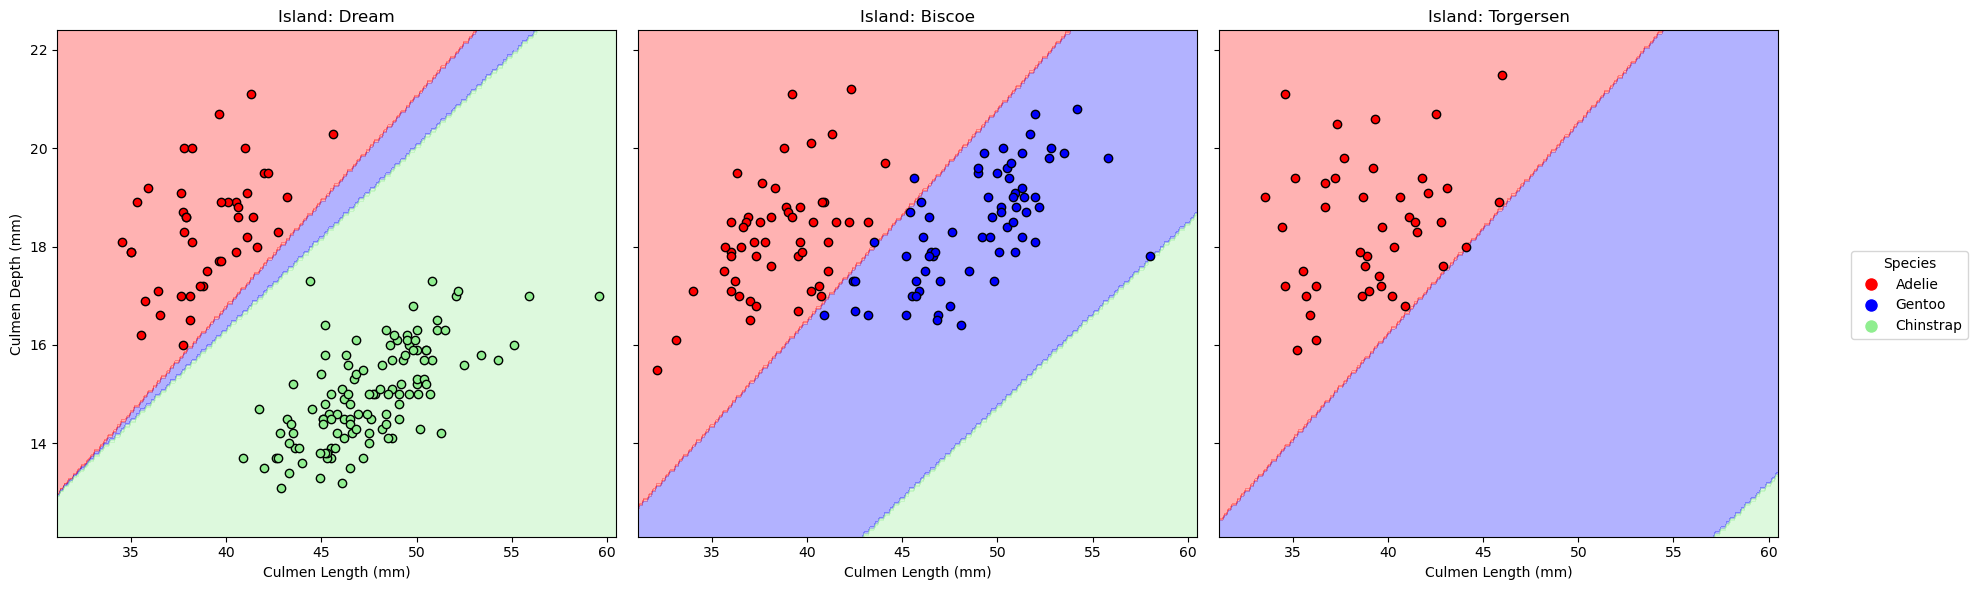

In [25]:
decision_regions_island(X, y, lg_best_model)

The visualization illustrates the decision boundaries for classifying penguin species (Adelie, Gentoo, and Chinstrap) based on culmen length and culmen depth across three islands: Dream, Biscoe, and Torgersen. Each subplot represents one island, with data points color-coded by species and shaded regions indicating the classification model’s predictions. The model effectively separates Gentoo penguins (blue) from the other species, as they occupy distinct regions. However, notable overlap exists between Adelie (red) and Chinstrap (green), particularly on Torgersen and Biscoe islands, suggesting potential misclassifications due to similar culmen features. The decision boundaries imply the use of a linear classifier, such as logistic regression, which assumes linear separability between classes. While this works reasonably well here, it has limitations in capturing complex relationships. If the relationship between features and species is nonlinear, the model may struggle, leading to reduced accuracy. Additionally, an imbalance in species representation could cause the model to favor the majority class, further increasing misclassifications. Advanced models like random forests could better handle such complexities and adapt to intricate data patterns, improving classification performance, let's do it!

### Random Forest Model
Random Forest Model makes predictions by making multiple decision trees. It takes a data, splits it into random subsets, trains trees to make predictions, then combines the trees. Using the forest of random trees, a decision is made by taking the majority prediction of all the trees in the forest, hence the name Random Forest Model. In the following code, we will use the Random Forest Model to predict the Penguin Species based on the Culmen Length and Depth, as well as the Island recorded within the Palmer Penguin Data set.

In [26]:
rfm_features = ["Island", "Culmen Length (mm)", "Culmen Depth (mm)"]
# X_train, X_test, y_train, y_test = data_splitting(rfm_penguins, "Species", test_size= 0.20)
rfm_X_train, rfm_X_test = X_train[rfm_features], X_test[rfm_features]

 Next, a parameter grid was used to select for the best RandomForestClassifier parameters to be used to make a prediction, using the cross_value_score method.

 Notice: this cell may take some time to run.

In [27]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, 10, None],
    'max_leaf_nodes': [5, 10, None],
}
# set a parameter grid to test over.

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(rfm_X_train, y_train.squeeze())
# run the RandomForestClassifier with all the parameters, and obtain the best estimator parameter
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=10)


Using the parameters found above, the random forest model is trained with the training data. Next, the testing dataset is passed through the model, and the model's prediction of penguin species is checked against the actual penguin species for accuracy.

In [28]:
rf = grid_search.best_estimator_
# set up a RandomForestClassifier with the best estimator parameters found above.

rf.fit(rfm_X_train, y_train)
# train it with the training data

rfm_y_pred = rf.predict(rfm_X_test)
# predict the testing data
accuracy = accuracy_score(y_test, rfm_y_pred)
# check for testing data accuracy
print("Accuracy:", accuracy)
# print the accuracy score.

Accuracy: 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


**Common misclassifications:**
There appears to be no significant common misclassifications. The model is able to predict the penguin species at a high accuracy, above 90%.

The accuracy of the model is visualized using a Confusion Matrix, where the prediction of the model is plotted against the actual data.

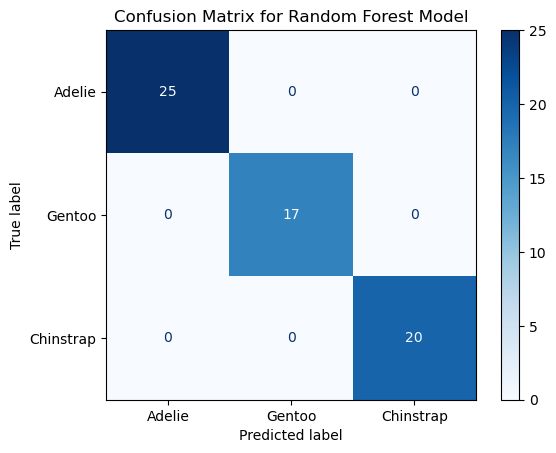

In [29]:
cm = confusion_matrix(y_test, rfm_y_pred)
# creates a confusion matrix with the test and prediction data
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Adelie", "Gentoo", "Chinstrap"])
# save the confusion matrix as a variable, and plot it.
cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix for Random Forest Model")

plt.show()

A sample decision tree within the random forest is visualized below. The actual Random Forest Model is made up of many such decision trees

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


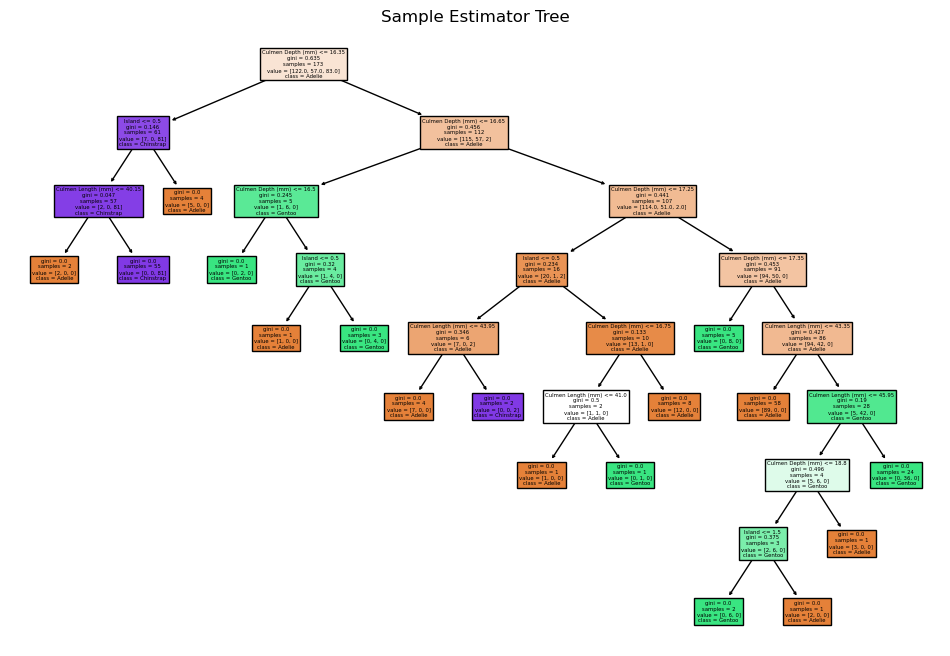

In [30]:
fn=["Island", "Culmen Length (mm)", "Culmen Depth (mm)"]
cn=["Adelie", "Gentoo", "Chinstrap"]
# create lists for the feature names and the species names

rf = grid_search.best_estimator_
# set up a RandomForestClassifier with the best estimator parameters found above.

rf.fit(rfm_X_train, y_train)
# train it with the training data

individual_tree = rf.estimators_[0]  # Get the first tree (you can choose any index)
# extract the first tree from the forest

plt.figure(figsize=(12, 8))
tree.plot_tree(individual_tree, feature_names=fn, class_names=cn, filled=True)
# plot the tree.
plt.title("Sample Estimator Tree")
plt.show()

Using the Decision Region plotting function above (in the logistic regression model), we first plot the decision regions against the data of penguins used to test the accuracy of the model across each island. It can be seen that the decision region successfully predicted each data point within the correct region.

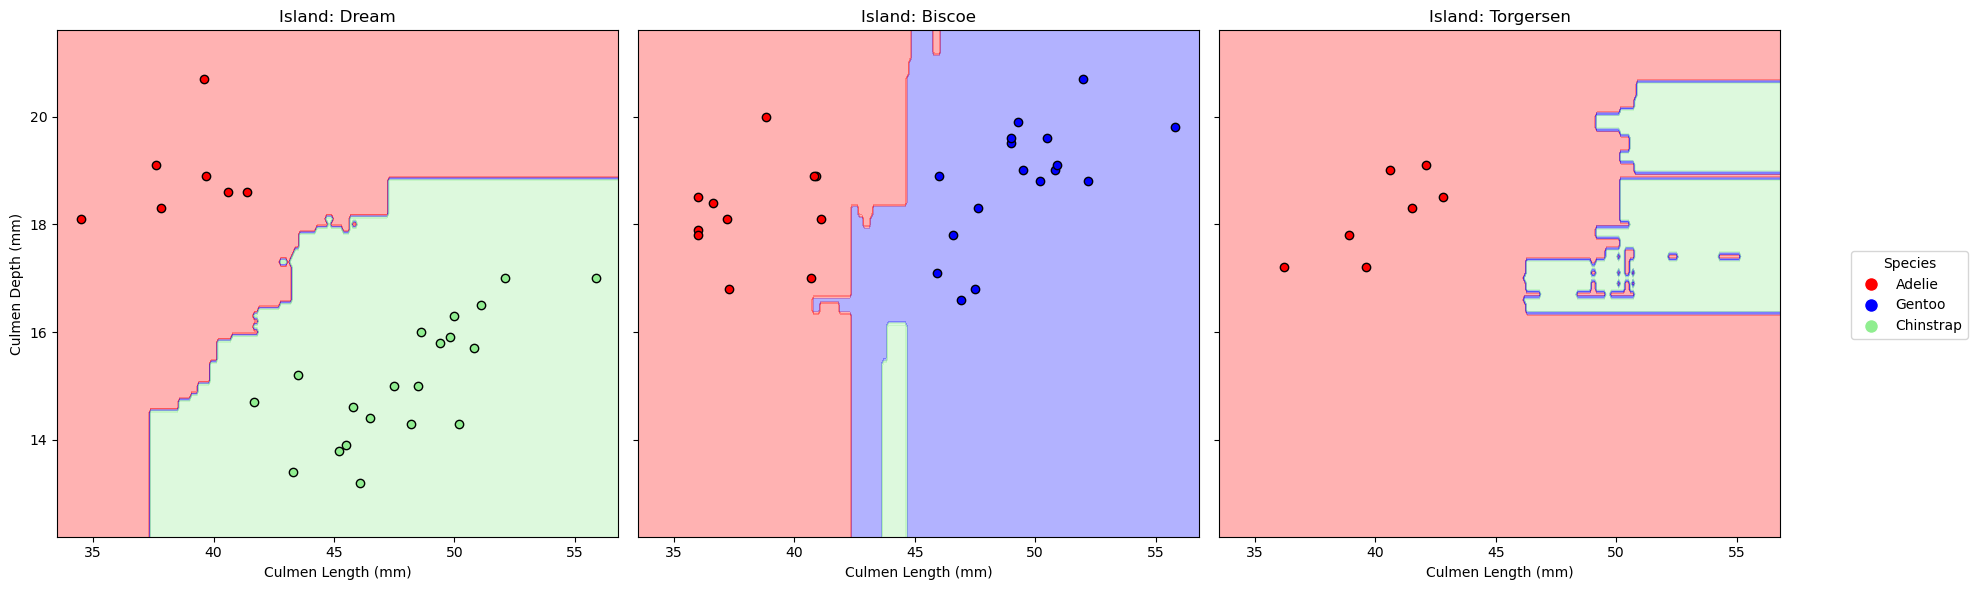

In [31]:
rf = grid_search.best_estimator_
rf.fit(rfm_X_train, y_train.squeeze())
# reload the random forest classifier.

decision_regions_island(X_test, y_test, rf)

Next, the Decision Region plotting function was used on all the datapoints from the Palmer Penguin dataset, to visualize it against all the Palmer Penguin data present. The decision regions are highly accurate.

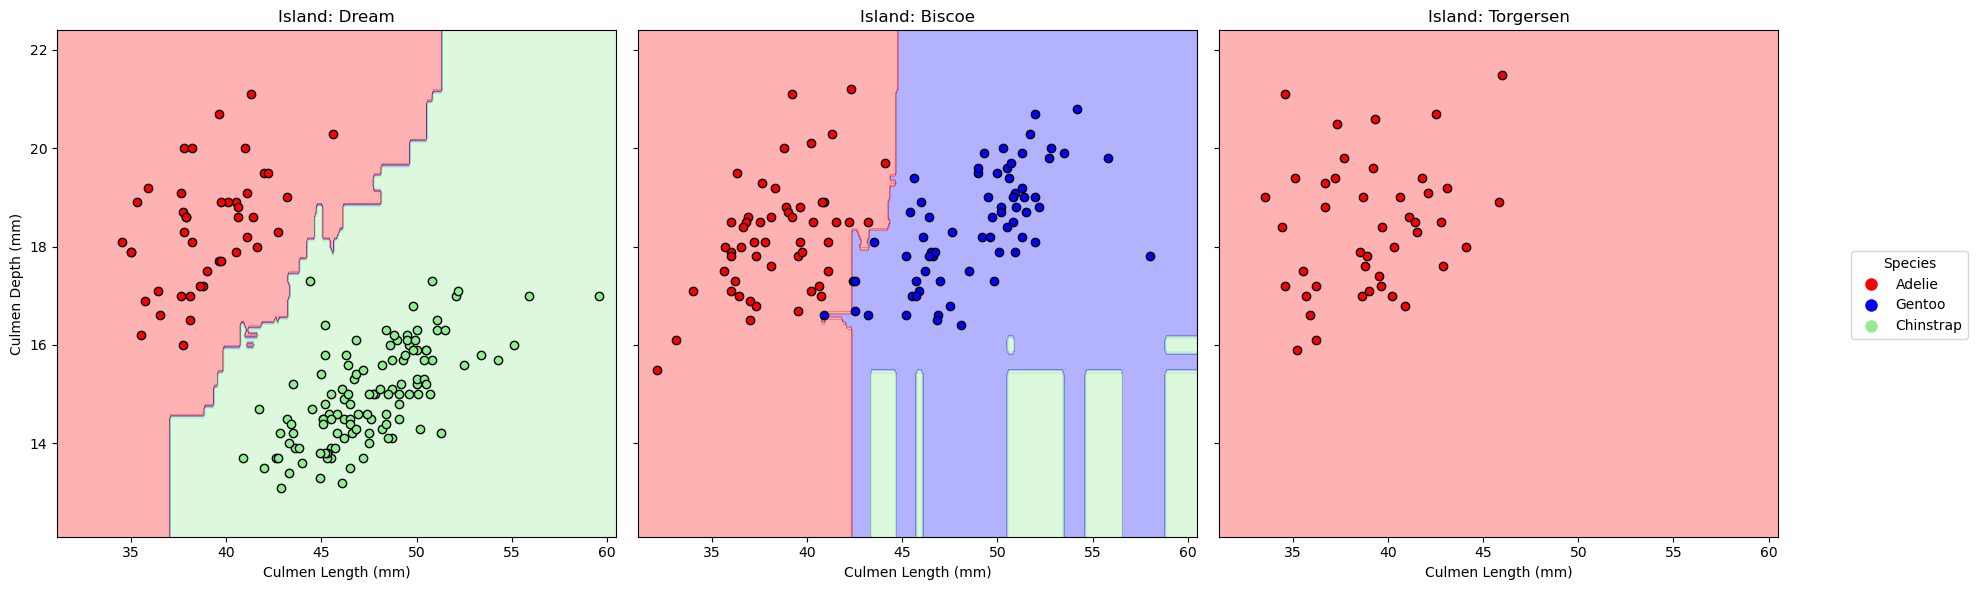

In [32]:
rf = grid_search.best_estimator_
rf.fit(rfm_X_train, y_train.squeeze())
# reload the random forest classifier.

decision_regions_island(X, y, rf)

In Summary, the Random Forest Model is a highly accurate machine learning model that can result in almost perfect predictions when given enough data. However, it is also very complexed, leading to longer run times, and the usage of large amounts of storage spaces. Because of the high amount of decision trees used to make a prediction, it can sometimes be difficult to understand the logic behind each prediction. Additionally, the Random Forest Model will not work with a small amount of data.

### Support Vector Machine(SVM)

The implementation of the Support Vector Machine (SVM) model uses culmen length, culmen depth, and island as features for penguin species classification. The grid search optimization identified the best hyperparameters as C=10, gamma='scale', and kernel='linear'. The cross-validation accuracy of 0.9846 on the training set indicates that the model performs exceptionally well under these configurations, achieving near-perfect classification on the training data.

In [33]:
svm_features = ["Island", "Culmen Length (mm)", "Culmen Depth (mm)"]
svm_X_train, svm_X_test = X_train[svm_features], X_test[svm_features]

In [34]:
# Cross-validation to choose complexity parameters.
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5)  # cross-validation with 5 folds inside GridSearchCV

# fit model with cross-validation
svm_model.fit(svm_X_train, y_train.squeeze())
# best hyperparameters
print("Best Parameters:", svm_model.best_params_)
best_svm_model = svm_model.best_estimator_

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [35]:
# cross-validation accuracy on training data
cv_scores = cross_val_score(best_svm_model, svm_X_train, y_train.squeeze(), cv=5)
print(f"\nCross-Validation Accuracy (Training Set): {cv_scores.mean():.4f}")


Cross-Validation Accuracy (Training Set): 0.9846


The reported cross-validation accuracy of 0.9846 for the Support Vector Machine (SVM) model on the training set reflects excellent performance, suggesting that the model is highly effective in distinguishing between penguin species using the selected features (culmen length, culmen depth, and island). The use of 5-fold cross-validation ensures that the evaluation accounts for variance within the training data and provides a robust measure of model performance. This result indicates that the linear kernel, combined with the hyperparameters (C=10, gamma='scale'), is well-suited for this dataset.

However, high cross-validation accuracy raises two considerations. First, while it demonstrates strong predictive power within the training data, it does not guarantee equivalent performance on unseen test data. Second, the near-perfect accuracy could be indicative of a dataset with clear separability or low noise, which might limit the model’s generalization if the test data contains more variability or noise.

To strengthen the analysis, the next steps should include evaluating the model on an independent test set and analyzing the confusion matrix to identify any misclassifications.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        20

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62

Testing Set Accuracy: 1.0000



Confusion Matrix:



<Axes: >

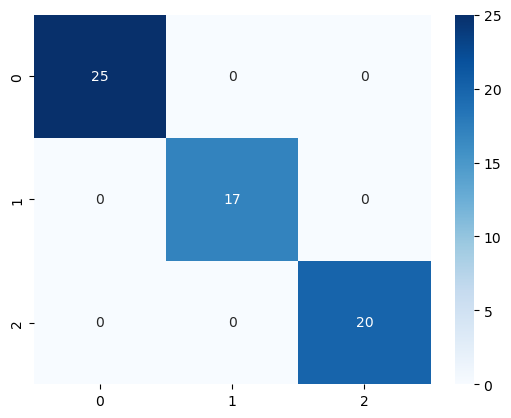

In [36]:
# Evaluation on unseen testing data, including a confusion matrix.
svm_y_pred = best_svm_model.predict(svm_X_test)
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred))
print(f"Testing Set Accuracy: {accuracy_score(y_test, svm_y_pred):.4f}\n\n")
print("\nConfusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, svm_y_pred), annot=True, fmt='d', cmap="Blues")

The testing results for the SVM model indicate perfect classification performance, achieving a testing set accuracy of 1.000. The classification report confirms that precision, recall, and F1-scores for all three species (Adelie, Chinstrap, and Gentoo) are 1.00. The confusion matrix reveals no misclassifications, with all predicted labels aligning perfectly with the true labels (25 Adelie, 17 Chinstrap, and 20 Gentoo correctly classified). This flawless performance on the testing data validates the model’s effectiveness and demonstrates its capability to generalize well beyond the training set.

The high accuracy across both training and testing data suggests that the dataset features (culmen length, culmen depth, and island) are highly discriminative for species classification. Additionally, the linear kernel chosen during hyperparameter tuning appears to have been an optimal choice for this dataset, as the decision boundaries are well-suited to the feature separability.

However, such perfect accuracy raises questions about the potential simplicity of the dataset, such as low variability, minimal noise, or an imbalanced test set. While these results are encouraging, further testing on an independent dataset or through cross-validation could provide additional confidence in the model’s robustness.


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       114
           1       1.00      0.98      0.99        50
           2       1.00      1.00      1.00        98

    accuracy                           1.00       262
   macro avg       1.00      0.99      1.00       262
weighted avg       1.00      1.00      1.00       262

Tranining Set Accuracy: 0.9962

Confusion Matrix:



<Axes: >

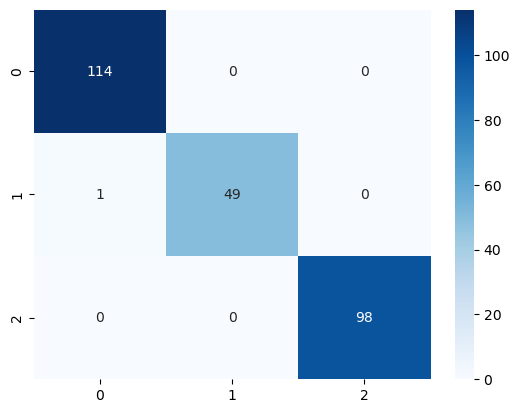

In [37]:
svm_y_pred = best_svm_model.predict(svm_X_train)
print("\nClassification Report:\n", classification_report(y_train, svm_y_pred))
print(f"Tranining Set Accuracy: {accuracy_score(y_train, svm_y_pred):.4f}")
print("\nConfusion Matrix:\n")
sns.heatmap(confusion_matrix(y_train, svm_y_pred), annot=True, fmt='d', cmap="Blues")

The confusion matrix further reinforces the strong performance, with the vast majority of predictions aligning perfectly with the true labels (114 Adelie, 49 Chinstrap correctly classified out of 50, and 98 Gentoo). The slight deviation from perfect accuracy (due to one misclassification) indicates a well-fitted model without significant overfitting.


**Decision Regions for All of the Data Set**

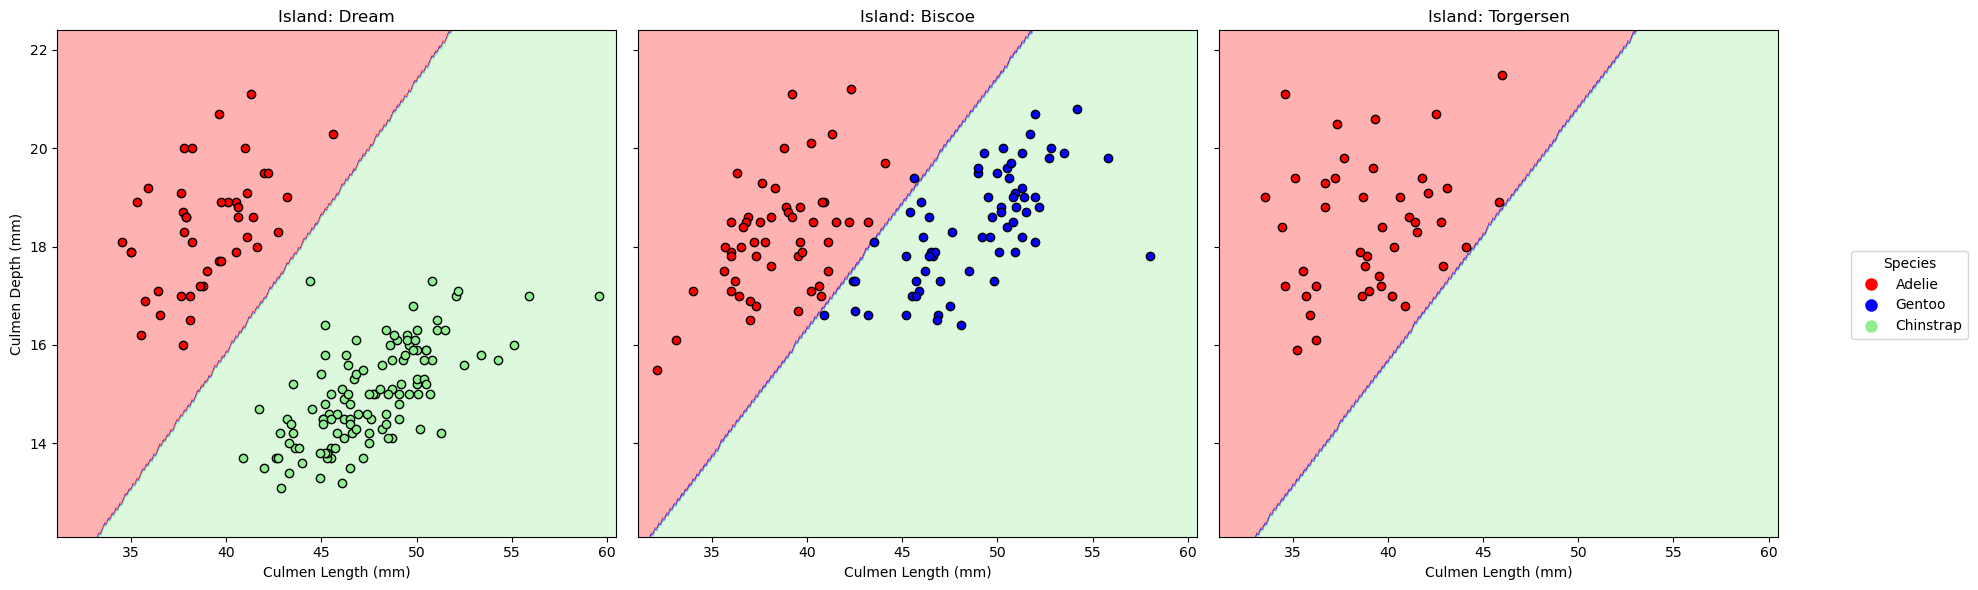

In [38]:
decision_regions_island(X, y, best_svm_model)

The regions are distinctly divided, reflecting the SVM’s capability to construct linear boundaries that effectively segment the feature space.

For Island Dream, the decision boundary clearly separates Adelie (red) and Chinstrap (green) species, with no apparent overlap, indicating well-separated data points. On Island Biscoe, the boundaries differentiate the Gentoo (blue) species effectively, while Adelie and Chinstrap have slight overlaps near the boundary, which could lead to minor misclassifications in cases of variability in feature values. On Island Torgersen, the model also displays well-defined decision regions, though the data is predominantly split between Adelie and Chinstrap, showing minimal complexity.

These decision regions confirm the linear kernel’s suitability for this dataset, as the species exhibit significant separability in the feature space.

**Decision Regions for the Training Data Set**

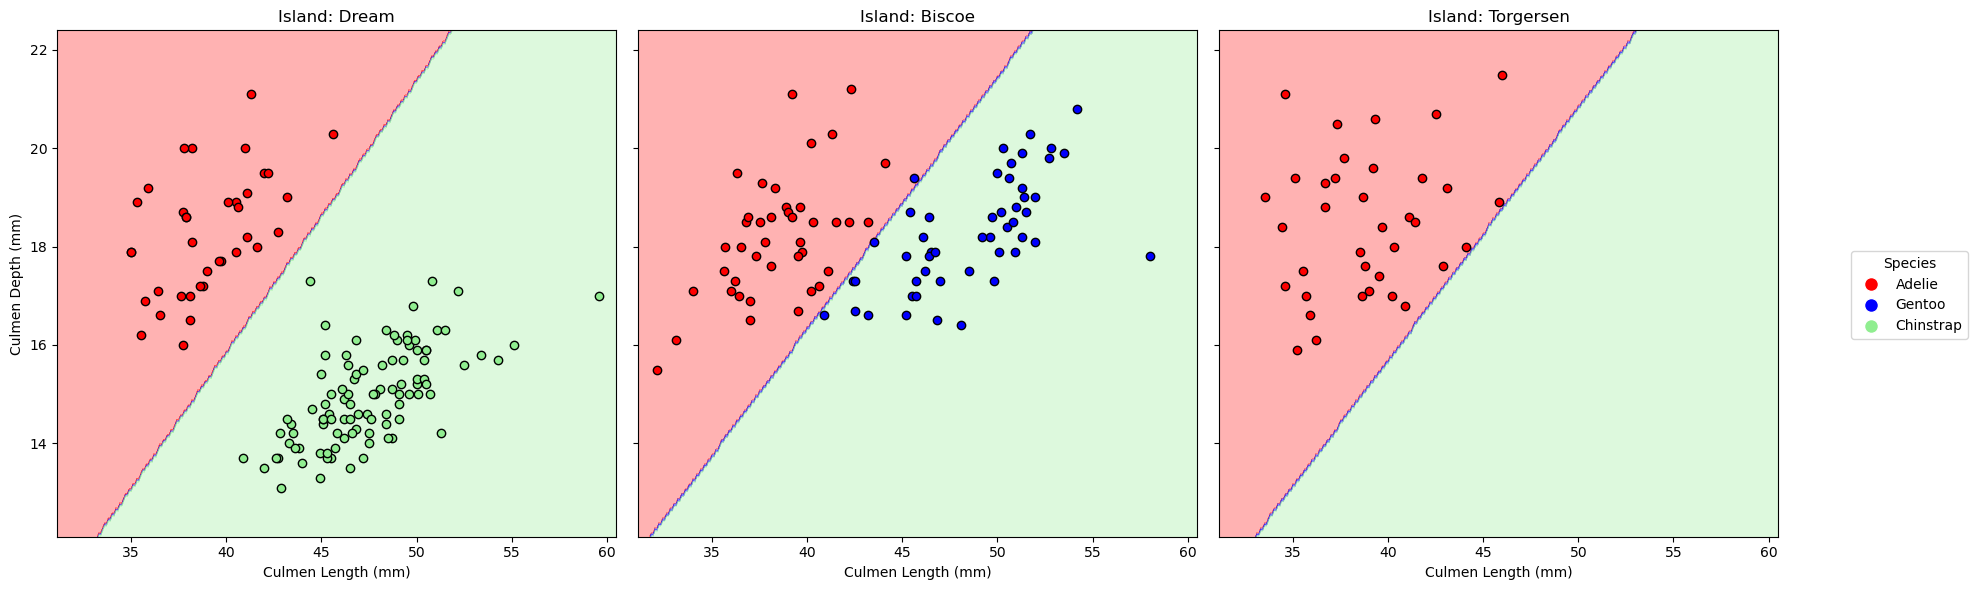

In [39]:
decision_regions_island(X_train, y_train, best_svm_model)

The decision regions for the training dataset visualize the linear SVM model’s boundaries separating the three penguin species (Adelie, Gentoo, and Chinstrap) across the islands (Dream, Biscoe, and Torgersen) based on culmen length and depth. On Island Dream, the boundaries perfectly separate Adelie (red) and Chinstrap (green), with no overlap, indicating clear feature separability. For Island Biscoe, Gentoo (blue) is well-separated from Adelie and Chinstrap, though the boundaries between Adelie and Chinstrap are closer, suggesting sensitivity to feature variations. On Island Torgersen, Adelie and Chinstrap are similarly well-separated without any visible misclassifications. These regions confirm that the linear kernel effectively models the feature separability in the training data, aligning with the near-perfect training accuracy. However, while the boundaries appear robust for the training data, further testing on unseen or noisier data is necessary to validate the model’s generalization.

**Decision Regions for the Test Data Set**

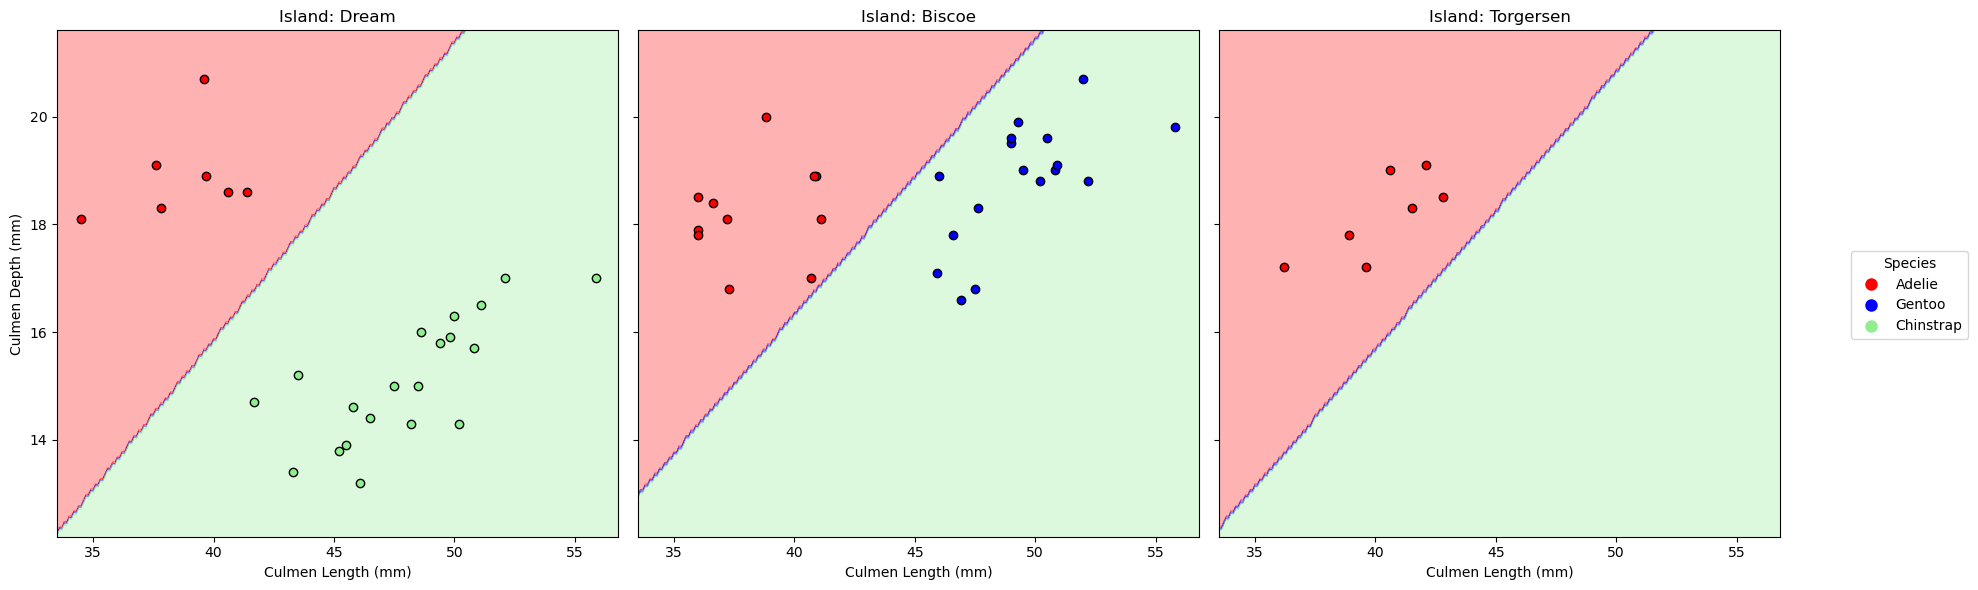

In [40]:
decision_regions_island(X_test, y_test, best_svm_model)

For Island Dream, the separation between Adelie (red region) and Chinstrap (green region) remains robust, with all test points correctly classified and no overlap near the boundary. On Island Biscoe, Gentoo (blue region) is distinctly separated from Adelie and Chinstrap, aligning well with the linear separability observed in the training dataset. On Island Torgersen, the boundaries also remain effective, clearly distinguishing Adelie and Chinstrap without any visible misclassifications. These results reflect the SVM model’s excellent performance on unseen data, corroborating its perfect test accuracy and confirming the adequacy of a linear kernel for this dataset. However, additional tests with more complex datasets or noisy features would further validate its robustness and highlight potential areas for improvement.

## Discussion


For the overall performance of the models the best model out of the three was the **Random Forest Model** due to its high accuracy. The features we recommend are **Island, Culmen Length(mm), and Culmen Depth (mm)**, which are highly accurate at predicting the penguin species. The qualitative data Island narrowed down the potential penguin species to 2 or 1 depending on which Island. The three species of penguins showed different trends in the combination of quantitative columns of Culmen Length and Depth.

The logistic regression model is simple and effective for linear data. However, its performance can be limited if the relationships in the data are nonlinear. It provides simplicity but is likely to underperform when compared to more flexible models. Despite its simplicity, Logistic Regression is often a strong baseline model, offering transparency in how predictions are made.The SVM model is suitable for high-dimensional data and performs well on complex decision boundaries. It is computationally intensive for larger datasets, requires scaling of input features, and is sensitive to choice of kernel and hyperparameters. The random forest model achieved high accuracy and handles nonlinear relationships well, is resistant to overfitting, and can handle categorical variables natively.

The model could be improved if there were additional biological features such as body mass, flipper length, or environmental features such as habitat data, nesting locations, climate zones, or proximity to water sources. Additionally, if more qualitative data such as behavioral traits or feeding patterns were available, that might enhance prediction accuracy. Another way to improve the accuracy of the models employed is through the use of more amounts of data. One concern about highly accurate machine learning models is that they may be overfitting against the data provided, prioritizing accuracy over overall trends. This can be solved by feeding the machine learning models with more training data, which reduces the chances of the model picking up on noise, and leads to better generalization of trends across the whole data.
